We will start by implementing the experiments conducted by Albert, Jeong, and Barabasi.

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import random
import time

In [21]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

Downloaded utils.py


## Creating an ER Random Graph and a WS Small World Graph

In [2]:
n = 10000
m = 20000
k = 4
p_ER = 1
p_WS = 0.1

ER = nx.gnm_random_graph(n, m)
# ER = nx.erdos_renyi_graph(n, p_ER)
WS = nx.watts_strogatz_graph(n, k, p_WS)
print(ER, WS)

## Reading in the Electrical Grid Graph and Using that

In [3]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

In [4]:
electrical_grid = read_graph('opsahl-powergrid/out.opsahl-powergrid')
print(electrical_grid)

## Helper Functions

In [70]:
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p
    
def target_edge_attack(G):
    pass

def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
    
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = []
    for pair in pairs:
        try:
            path = nx.shortest_path_length(G, *pair)
            lengths.append(path)
        except:
            pass
    return lengths

def average_shortest_length(G):
    return np.mean(sample_path_lengths(G))

def clusters(G):
    largest = len(max(nx.connected_components(G), key=len))
    sizes = [len(i) for i in nx.connected_components(G)]
    sizes.remove(largest)
    average_isolated = np.mean(sizes)
    return largest /len(G.nodes()), average_isolated

## Implementing a Random Attack

In [107]:
def random_attack(G, k):
    """Returns a graph with k nodes removed at random"""
    nodes_removed = random.sample(list(G.nodes),k=k)
    G.remove_nodes_from(nodes_removed)
    
def run_random(WS, ER, step=.01):
        
    WS = WS.copy()
    ER = ER.copy()
    k = int(.8/step)
    f_step = np.linspace(1,k,k)*step
    
    er_max, er_avg = [], []
    ws_max, ws_avg = [], []
    
    en = len(ER.nodes())
    wn = len(WS.nodes())

    t0 = time.time()
    for i in f_step:
        #remove nodes
        random_attack(ER, int(step*en))
        random_attack(WS, int(step*wn))

        #calculate cluster properties
        erl, era = clusters(ER)
        wsl, wsa = clusters(WS)

        #add cluster properties
        er_max.append(erl)
        er_avg.append(era)
        ws_max.append(wsl)
        ws_avg.append(wsa)
    print("time: ", time.time() - t0)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(f_step, er_max)
    plt.plot(f_step, ws_max)
    plt.legend(['er', 'ws'])
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Largest Cluster Size / Number of Nodes")
    plt.title("Relative Size of Largest Cluster (Random)")

    plt.subplot(1,2,2)
    plt.plot(f_step, er_avg)
    plt.plot(f_step, ws_avg)
    plt.legend(['er', 'ws'])
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Isolated Cluster Size")
    plt.title("Size of Average Cluster (Random)")
    plt.show()

### Testing Random Attack

average shortest length:  5.476
largest relative cluster:  1.0
average cluster size:  nan
number of nodes:  100


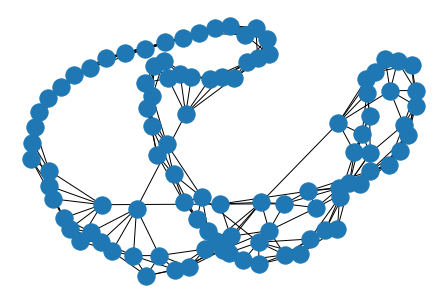

In [108]:
WS = nx.watts_strogatz_graph(100, 7, p_WS)
nx.draw(WS)
largest_cluster, avg_cluster = clusters(WS)

print("average shortest length: ", average_shortest_length(WS))
print("largest relative cluster: ", largest_cluster)
print("average cluster size: ", avg_cluster)
print("number of nodes: ", len(WS.nodes()))

By removing 50 nodes from our original graph of 100 nodes we are testing a random attack where each node has a 50% chance of failing.

average shortest length:  3.6573604060913705
largest relative cluster:  0.44
average cluster size:  14.0
number of nodes:  50


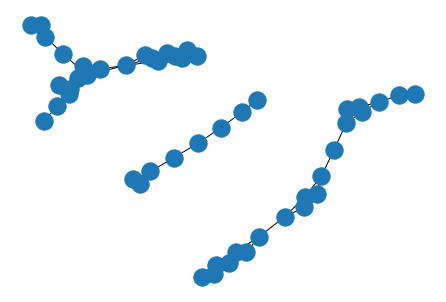

In [109]:
random_attack(WS, 50)
nx.draw(WS)
largest_cluster, avg_cluster = clusters(WS)

print("average shortest length: ", average_shortest_length(WS))
print("largest relative cluster: ", largest_cluster)
print("average cluster size: ", avg_cluster)
print("number of nodes: ", len(WS.nodes()))

### Random Attack on Large Graphs

We want to replicate the results of the paper by running a random attack on random and scale-free graphs that reflect the properties of the graphs used by the authors.

time:  0.2709624767303467


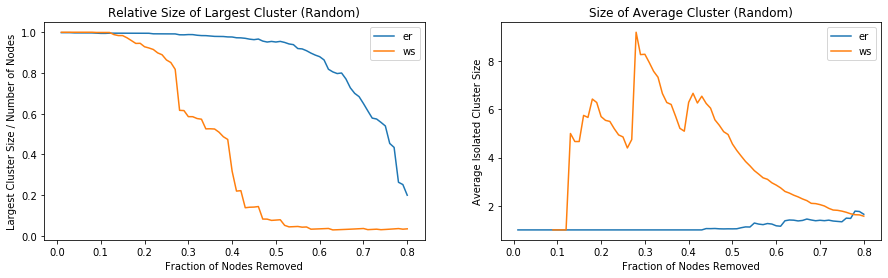

In [114]:
#ER paramters
n = 1000
m = 3000

#WS parameters
k = 4
p_WS = 0.05

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)

run_random(WS, ER, step=.01)

## Conducting Targeted Attacks

In [118]:
def target_node_attack(G, k):
    """
    Targets k nodes with the most connections, then removes those node.
    G: Graph to target
    """
    for i in range(k):
        degrees = dict(G.degree())
        target = max(degrees, key=degrees.get)
        G.remove_node(target)
        
def run_targeted(WS, ER, step=.01):
    
    WS = WS.copy()
    ER = ER.copy()
    k = int(.8/step)
    f_step = np.linspace(1,k,k)*step
    
    er_max, er_avg = [], []
    ws_max, ws_avg = [], []
    
    en = len(ER.nodes())
    wn = len(WS.nodes())
    t0 = time.time()
    for i in f_step:
        #remove nodes
        target_node_attack(ER, int(step*en))
        target_node_attack(WS, int(step*wn))

        #calculate cluster properties
        erl, era = clusters(ER)
        wsl, wsa = clusters(WS)

        #add cluster properties
        er_max.append(erl)
        er_avg.append(era)
        ws_max.append(wsl)
        ws_avg.append(wsa)
    print("time: ", time.time() - t0)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(f_step, er_max)
    plt.plot(f_step, ws_max)
    plt.legend(['er', 'ws'])
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Largest Cluster Size / Number of Nodes")
    plt.title("Relative Size of Largest Cluster (Targeted)")

    plt.subplot(1,2,2)
    plt.plot(f_step, er_avg)
    plt.plot(f_step, ws_avg)
    plt.legend(['er', 'ws'])
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Isolated Cluster Size")
    plt.title("Size of Average Cluster (Targeted)")
    plt.show()

### Targeted Attacks on Large Graphs


10.0
time:  0.7389590740203857


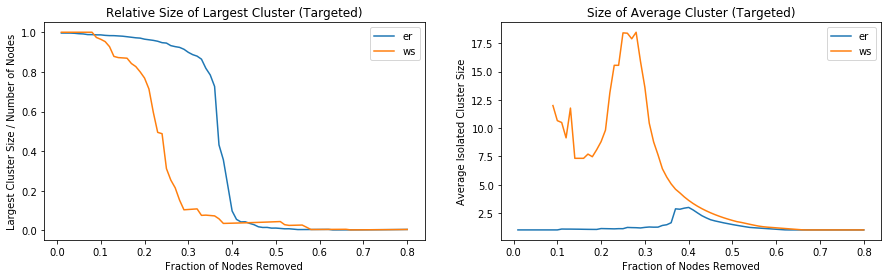

In [116]:
#ER paramters
n = 1000
m = 3000

#WS parameters
k = 4
p_WS = 0.05

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)

run_targeted(WS, ER, step=.01)

## Testing Facebook Graph

The facebook graph should reflect a real small-world graph example. We can compare the facebook data to a random graph of similar size.

4039
time:  2.319017171859741


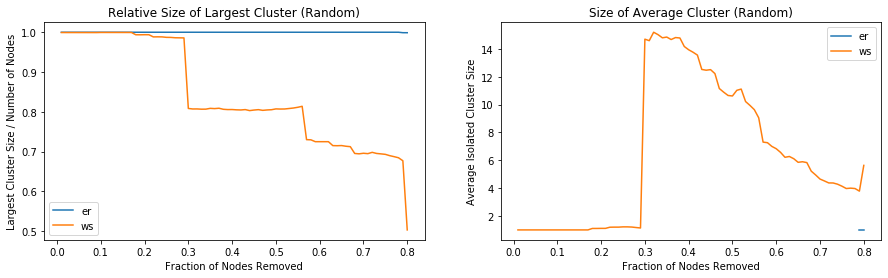

time:  10.874051570892334


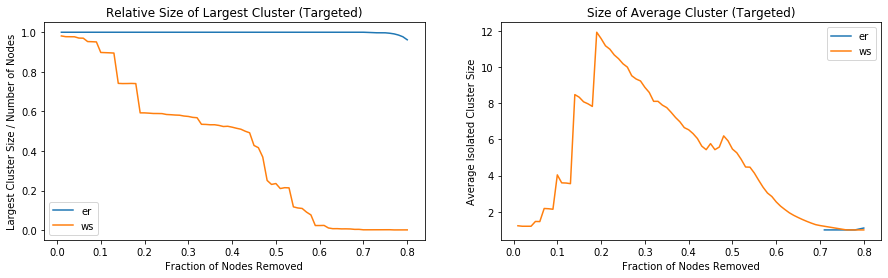

In [119]:
download('https://snap.stanford.edu/data/facebook_combined.txt.gz')
fb = read_graph('facebook_combined.txt.gz')

n = len(fb)
m = len(fb.edges())

ER =  nx.gnm_random_graph(n, m)

run_random(fb, ER)
run_targeted(fb, ER)